In [1]:
from copy import deepcopy
import os
from pathlib import Path
import shutil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from citylearn.citylearn import CityLearnEnv
from citylearn.utilities import read_json, write_json

In [6]:
source_directory = Path('/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/3DEM/data/Climate_Zone_1/')
model_source_directory = Path('/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/3DEM/Building_models/')
target_directory = Path('/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/citylearn/CityLearn/citylearn/data/baeda_3dem/')
building_attributes = read_json(os.path.join(source_directory, 'building_attributes.json'))
solar_generation = pd.read_csv(os.path.join(source_directory, 'solar_generation_1kW.csv'))
schema = read_json(Path('/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/citylearn/CityLearn/citylearn/data/citylearn_challenge_2021/schema.json'))
earliest_ix, latest_ix = 3624, 6552
start_ix, end_ix = earliest_ix, latest_ix - 30*24

if os.path.isdir(target_directory):
    shutil.rmtree(target_directory)
else:
    pass

os.makedirs(target_directory, exist_ok=True)

# prepare building data files
for f in os.listdir(source_directory):
    if f.startswith('Building_'):
        building_name = f.split('.')[0]
        building_data = pd.read_csv(os.path.join(source_directory, f))
        building_data['Heating Load [kWh]'] = 0
        building_data['Solar Generation [W/kW]'] = 1000*solar_generation.iloc[:,1]
        building_data['Occupant Count [people]'] = building_data['Occupancy']
        building_data['Cooling Temperature Set Point [C]'] = building_data['Set Point']
        building_data['Heating Temperature Set Point [C]'] = None
        building_data['Cooling Device Load Schedule [On/Off]'] = 1
        building_data.loc[building_data['Cooling Temperature Set Point [C]'] == 30, 'Cooling Device Schedule [On]'] = False
        building_data['Heating Device Load Schedule [On/Off]'] = 0
        building_data = building_data[[
            'Month', 'Hour', 'Day Type', 'Daylight Savings Status', 'Indoor Temperature [C]',
            'Average Unmet Cooling Setpoint Difference [C]', 'Indoor Relative Humidity [%]',
            'Equipment Electric Power [kWh]', 'DHW Heating [kWh]', 'Cooling Load [kWh]', 'Heating Load [kWh]',
            'Solar Generation [W/kW]', 'Occupant Count [people]', 'Cooling Temperature Set Point [C]',
            'Heating Temperature Set Point [C]', 'Cooling Device Load Schedule [On/Off]', 'Heating Device Load Schedule [On/Off]'
        ]].iloc[start_ix:end_ix].copy()
        building_data.to_csv(os.path.join(target_directory, f), index=False)
        shutil.copyfile(
            os.path.join(model_source_directory, f'{building_name}.pth'), 
            os.path.join(target_directory, f'{building_name}.pth')
        )

    else:
        pass

# prepare weather file
weather_data = pd.read_csv(os.path.join(source_directory, 'weather_data.csv'))
weather_data = weather_data.iloc[start_ix:end_ix].copy()
weather_data = weather_data.dropna(axis=1)
weather_data.to_csv(os.path.join(target_directory, 'weather.csv'), index=False)

# prepare pricing file
pricing_data = pd.read_csv(os.path.join(source_directory, 'electricity_price.csv'))
pricing_data = pricing_data.iloc[start_ix:end_ix].copy()
pricing_data['Electricity Pricing [$]'] = pricing_data['Price']
pricing_data = pricing_data.drop(columns=['Price'])

for hour in [1, 2, 3]:
    pricing_data[f'{hour}h Prediction Electricity Pricing [$]'] = np.roll(pricing_data['Electricity Pricing [$]'],-hour)

pricing_data.to_csv(os.path.join(target_directory, 'pricing.csv'), index=False)
new_observations = ['cop', 'q_cooling', 'occupant_count', 'T_lstm', 'cooling_temperature_set_point',  'heating_temperature_set_point', 'cooling_temperature_delta', 'heating_temperature_delta']

# prepare schema
schema['simulation_start_time_step'] = 0
schema['simulation_end_time_step'] = building_data.shape[0] - 1
schema['observations'] = {
    **schema['observations'],
    'cooling_device_cop': {'active': True, 'shared_in_central_agent': False},
    'heating_device_cop': {'active': True, 'shared_in_central_agent': False},
    'cooling_demand': {'active': True, 'shared_in_central_agent': False},
    'heating_demand': {'active': False, 'shared_in_central_agent': False},
    'occupant_count': {'active': True, 'shared_in_central_agent': False},
    'indoor_dry_bulb_temperature': {'active': True, 'shared_in_central_agent': False},
    'cooling_dry_bulb_temperature_set_point': {'active': True, 'shared_in_central_agent': False},
    'heating_dry_bulb_temperature_set_point': {'active': False, 'shared_in_central_agent': False},
    'cooling_dry_bulb_temperature_delta': {'active': True, 'shared_in_central_agent': False},
    'heating_dry_bulb_temperature_delta': {'active': False, 'shared_in_central_agent': False},
}
schema['actions'] = {
    **schema['actions'],
    'cooling_device': {'active': True},
    'heating_device': {'active': False},
    'electrical_storage': {'active': False}
}
schema['agent']['type'] = 'citylearn.agents.sac.SACBasicRBC'
schema['agent']['attributes'] = {
    **schema['agent']['attributes'],
    'start_training_time_step': int(end_ix - start_ix), # normalize buffer after 1 episode
    "end_exploration_time_step": int(end_ix - start_ix) + 1, # stop random/rbc actions after 1 episode
    "deterministic_start_time_step": int((end_ix - start_ix) * 20), # never take deterministic actions while training
    "batch_size": 512,
    "lr": 0.001,
    "discount": 0.9,
    "alpha": 1.0,
}
# schema['reward_function']['type'] = 'citylearn.reward_function.BuildingDynamicsReward'
schema['buildings'] = {}

for i, b in enumerate(building_attributes):
    b_data = {
        'include': True if i == 0 else False,
        'energy_simulation': f'{b}.csv',
        'weather': 'weather.csv',
        'carbon_intensity': None,
        'pricing': 'pricing.csv',
        # 'type': 'citylearn.building.LSTMDynamicsBuilding',
    }

    # cooling device
    b_data['cooling_device'] = {
        'type': 'citylearn.energy_model.HeatPump',
        'autosize': True,
        'attributes': {
            'nominal_power': None,
            'efficiency': building_attributes[b]['Heat_Pump']['technical_efficiency'],
            'target_cooling_temperature': building_attributes[b]['Heat_Pump']['t_target_cooling'],
            'target_heating_temperature': building_attributes[b]['Heat_Pump']['t_target_heating']
        }
    }

    # dhw device
    b_data['dhw_device'] = {
        'type': 'citylearn.energy_model.ElectricHeater',
        'autosize': True,
        'attributes': {
            'nominal_power': None,
            'efficiency': building_attributes[b]['Electric_Water_Heater']['efficiency']
        }
    }

    # cooling storage
    b_data['cooling_storage'] = {
        'type': 'citylearn.energy_model.StorageTank',
        'autosize': True,
        'autosize_attributes': {
            'safety_factor': building_attributes[b]['Chilled_Water_Tank']['capacity']
        },
        'attributes': {
            'capacity': None,
            'loss_coefficient': building_attributes[b]['Chilled_Water_Tank']['loss_coefficient']
        }
    }

    # dhw storage
    b_data['dhw_storage'] = {
        'type': 'citylearn.energy_model.StorageTank',
        'autosize': True,
        'autosize_attributes': {
            'safety_factor': building_attributes[b]['DHW_Tank']['capacity']
        },
        'attributes': {
            'capacity': None,
            'loss_coefficient': building_attributes[b]['DHW_Tank']['loss_coefficient']
        }
    }

    # inactive observations and actions
    b_data['inactive_observations'] = ['heating_storage_soc', 'electrical_storage_soc']
    b_data['inactive_observations'] += [
        'solar_generation', 'diffuse_solar_irradiance', 'diffuse_solar_irradiance_predicted_6h',
        'diffuse_solar_irradiance_predicted_12h', 'diffuse_solar_irradiance_predicted_24h',
        'direct_solar_irradiance_predicted_6h',
        'direct_solar_irradiance_predicted_12h', 'direct_solar_irradiance_predicted_24h'
    ] if building_attributes[b]['Solar_Power_Installed(kW)'] == 0 else []

    b_data['inactive_actions'] = ['heating_storage', 'electrical_storage']

    # dynamics
    b_data['dynamics'] = {
        'type': 'citylearn.dynamics.LSTMDynamics',
        'attributes': {
            'state_dict_filename': f'{b}.pth',
            'input_size': building_attributes[b]['Model_dynamics']['n_features'],
            'hidden_size': building_attributes[b]['Model_dynamics']['n_hidden'],
            'num_layers': building_attributes[b]['Model_dynamics']['n_layers'],
            'batch_first': True,
            'lookback': building_attributes[b]['Model_dynamics']['lookback']
        }
    }

    schema['buildings'][b] = deepcopy(b_data)

write_json(os.path.join(target_directory, 'schema.json'), schema)

In [7]:
# initialize environment
dataset_name = 'baeda_3dem'
env = CityLearnEnv(dataset_name, central_agent=True)
agents = env.load_agent()
episodes = 10

for e in range(episodes):
    observations = env.reset()

    while not env.done:
        print(f'\rEpisode: {e}, Time step: {env.time_step + 1}/{env.time_steps}', end=' '*50)
        actions = agents.select_actions(observations)

        # apply actions to env
        next_observations, rewards, _, _ = env.step(actions)

        # update policies
        agents.add_to_buffer(observations, actions, rewards, next_observations, done=env.done)
        observations = [o for o in next_observations]
        
    print()
    # print cost functions at the end of episode
    print('Mean reward:', np.array(np.array(env.rewards, dtype=object).sum()).mean())
    for n, nd in env.evaluate().groupby('name'):
        nd = nd.pivot(index='name', columns='cost_function', values='value').round(3)
        print(n, ':', nd.to_dict('records'))

Episode: 0, Time step: 2207/2208                                                  
Mean reward: -2.790605699182438
Building_1 : [{'carbon_emissions': nan, 'electricity_consumption': 0.966, 'pricing': 0.911, 'zero_net_energy': 0.96}]
District : [{'1 - load_factor': 1.183, 'average_daily_peak': 0.886, 'carbon_emissions': nan, 'electricity_consumption': 0.966, 'peak_demand': 0.845, 'pricing': 0.911, 'ramping': 1.224, 'zero_net_energy': 0.96}]
Episode: 1, Time step: 2207/2208                                                  
Mean reward: -2.899053394062469
Building_1 : [{'carbon_emissions': nan, 'electricity_consumption': 1.003, 'pricing': 0.987, 'zero_net_energy': 1.003}]
District : [{'1 - load_factor': 1.3, 'average_daily_peak': 1.13, 'carbon_emissions': nan, 'electricity_consumption': 1.003, 'peak_demand': 1.115, 'pricing': 0.987, 'ramping': 1.76, 'zero_net_energy': 1.003}]
Episode: 2, Time step: 2207/2208                                                  
Mean reward: -2.87146392354535


AttributeError: 'Building' object has no attribute 'ideal_indoor_dry_bulb_temperature'

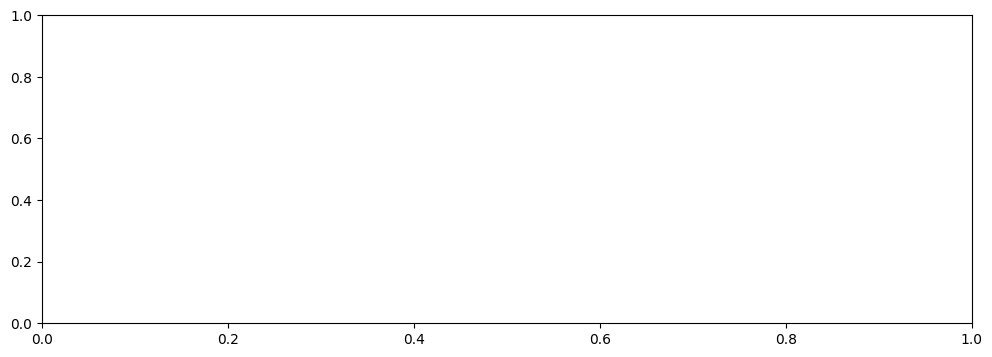

In [8]:
building = env.buildings[0]
start_ix, end_ix = 0, 24
fig, ax = plt.subplots(1, 1, figsize=(12,4))
ax.plot(building.ideal_indoor_dry_bulb_temperature[start_ix:end_ix], label='t_ideal')
ax.plot(building.energy_simulation.indoor_dry_bulb_temperature[start_ix:end_ix], label='t_control')
ax.legend()
plt.show()

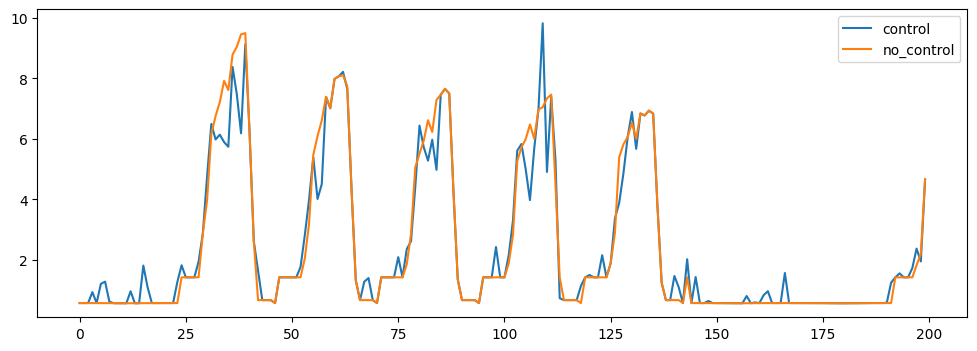

In [12]:
building = env.buildings[0]
start_ix, end_ix = 0, 200
fig, ax = plt.subplots(1, 1, figsize=(12,4))
ax.plot(building.net_electricity_consumption[start_ix:end_ix], label='control')
ax.plot(building.net_electricity_consumption_without_storage[start_ix:end_ix], label='no_control')
ax.legend()
plt.show()